# The problem:

Train an LSTM to solve the `XOR` problem: that is, given a sequence of bits, determine its parity. The [LSTM][2] should consume the sequence, one bit at a time, and then output the correct answer at the sequence’s end. Test the two approaches below:

  * Generate a dataset of random 100,000 binary strings of length 50. Train the LSTM; what performance do you get?
  * Generate a dataset of random 100,000 binary strings, where the length of each string is independently and randomly chosen between 1 and 50. Train the LSTM. Does it succeed? What explains the difference?


[1]: https://blog.openai.com/requests-for-research-2/
[2]: https://arxiv.org/abs/1706.03762

## The `XOR` problem?

The `XOR` problem arises when trying to train a single perceptron as an `XOR` gate:

In [192]:
import torch
from torch.autograd import Variable
from itertools import product
import operator

In [193]:
# Create XOR gate inputs & outputs.
bits = [0, 1]
num_input_bits = 2

inputs = [list(pair) for pair in product(bits, repeat=num_input_bits)]
outputs = [operator.and_(*pair) for pair in inputs]

inputs = Variable(torch.Tensor(inputs), requires_grad=True)
outputs = Variable(torch.Tensor(outputs).unsqueeze(-1))

In [194]:
print inputs.shape
print outputs.shape

torch.Size([4, 2])
torch.Size([4, 1])


In [195]:
import torch.nn as nn

In [196]:
# Build model.
num_output_bits = 1

model = nn.Sequential(
            nn.Linear(num_input_bits, num_output_bits),
            nn.Sigmoid()
        )

In [197]:
model(inputs)

Variable containing:
 0.5807
 0.4202
 0.4368
 0.2887
[torch.FloatTensor of size 4x1]

In [198]:
import torch.optim as optim

In [199]:
# Train model.
losses = []
num_epochs = 2000

loss_fxn = nn.BCELoss()
optimizer = optim.RMSprop(model.parameters())

for _ in xrange(num_epochs):
    predictions = model(inputs)
    loss = loss_fxn(predictions, outputs)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    losses.append(loss.data[0])

In [200]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()  # Applies seaborn style defaults to matplotlib

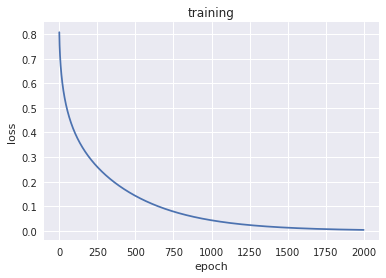

In [201]:
# Plot losses
plt.plot(losses);
plt.xlabel('epoch');
plt.ylabel('loss');
plt.title('training');

In [202]:
import numpy as np

In [203]:
np.c_[xx.ravel(), yy.ravel()]

array([[-1.  , -1.  ],
       [-0.99, -1.  ],
       [-0.98, -1.  ],
       ...,
       [ 1.97,  1.99],
       [ 1.98,  1.99],
       [ 1.99,  1.99]])

In [204]:
import matplotlib

In [205]:
inputs = inputs.data.numpy()
outputs = outputs.data.numpy()

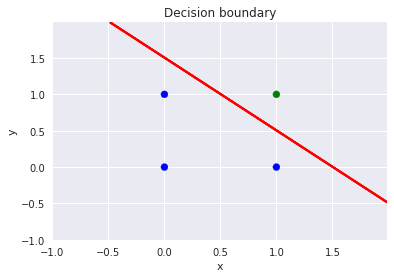

In [218]:
# View results.
# https://stackoverflow.com/questions/22294241/plotting-a-decision-boundary-separating-2-classes-using-matplotlibs-pyplot
# https://stackoverflow.com/questions/12487060/matplotlib-color-according-to-class-labels
colors = ['blue', 'green']
plt.scatter(inputs[:, 0], inputs[:, 1], c=outputs.ravel(), cmap=matplotlib.colors.ListedColormap(colors));
plt.xlabel('x');
plt.ylabel('y');
plt.title('decision boundary')

step = 0.01
x_min, x_max = min(bits) - 1, max(bits) + 1
y_min, y_max = x_min, x_max

xx, yy = np.meshgrid(
            np.arange(x_min, x_max, step),
            np.arange(y_min, y_max, step)
        )

mesh_inputs = np.c_[xx.ravel(), yy.ravel()]
predictions = model(Variable(torch.Tensor(mesh_inputs), requires_grad=False))
predictions = predictions.data.numpy().reshape(xx.shape)

plt.contour(xx, yy, np.around(predictions), colors=['red']);
plt.plot();

In [126]:
np.around(predictions)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.]], dtype=float32)

In [82]:
xx.shape

(300, 300)

a single perceptron finds a single linear decision boundary. Because `XOR` is not [linearly seperable][1], i.e. there is no single line which can seperate the two classes, we must either:
  * use techniques which find non-linear decision boundaries or --> incorrect?
  * add an additional perceptron, to the same layer, i.e. introduce a second linear decision boundary.
  
For more information, as well as visualizations, see:
  * [Quora: What is XOR problem in neural networks?][2]
  * [XOR problem theory][3]


[1]: https://en.wikipedia.org/wiki/Linear_separability
[2]: https://www.quora.com/What-is-XOR-problem-in-neural-networks
[3]: http://home.agh.edu.pl/~vlsi/AI/xor_t/en/main.htm

## What does `XOR` have to do with parity?

As noted on [Wikipedia][1], parity, in this context, refers to,

> ...the evenness or oddness of the number of bits with value one within a given set of bits...It can be calculated via an XOR sum of the bits, yielding 0 for even parity and 1 for odd parity.


[1]: https://en.wikipedia.org/wiki/Parity_bit#Parity

# The experiments:

## Build/load the dataset.

In [1]:
import random

In [146]:
def build_dataset(num_examples, max_seq_len, fixed_seq_len=True):
    X = []
    y = []
    
    for _ in xrange(num_examples):
        if not fixed_seq_len:
            seq_len = random.randint(1, max_seq_len)
        else:
            seq_len = max_seq_len
        
        bin_seq = [random.choice([0, 1]) for _ in xrange(seq_len)]
        parity = int(sum(bin_seq) % 2 !=0)
        
        X.append(bin_seq)
        y.append(parity)
    
    return X, y

In [164]:
str_len = 50
num_examples = 100000

X, y = build_dataset(num_examples, str_len)

## Prepare data for training

In [165]:
import torch
from torch.autograd import Variable
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
# from sklearn.model_selection import train_test_split

In [166]:
def one_hot_encode(data):
    result = []
    
    for bin_seq in data:
        one_hot_bin = []
        for bit in bin_seq:
            one_hot_bit = [0, 0]
            one_hot_bit[bit] = 1
            
            one_hot_bin.append(one_hot_bit)
            
        result.append(one_hot_bin)
            
    return result

In [167]:
X = one_hot_encode(X)

In [168]:
X = torch.Tensor(X)
y = torch.Tensor(y)
train = DataLoader(TensorDataset(X, y), batch_size=10)
# X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=train_size)

In [169]:
X.shape

torch.Size([100000, 50, 2])

## Build the network

In [170]:
import torch.nn as nn

In [194]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, batch_first):
        super(Model, self).__init__()
        self.LSTM = nn.LSTM(input_size=input_size, hidden_size=hidden_size, 
                            num_layers=num_layers, batch_first=batch_first)
#         self.Linear = nn.Linear(hidden_size, 1)
        self.Softmax = nn.Softmax()
        
    def forward(self, inputs):
        outputs, _ = self.LSTM(inputs)
        outputs = outputs[:, -1]  # get last timestep only
#         outputs = self.Linear(outputs)
        return self.Softmax(outputs)

In [203]:
model = Model(input_size=X.shape[-1], hidden_size=1, num_layers=1, batch_first=True).cuda()

## Train the network

In [204]:
from torch.optim import RMSprop
from torch.nn import BCELoss

In [205]:
loss_fxn = BCELoss()
optimizer = RMSprop(model.parameters())

In [206]:
for epoch in xrange(5):
    losses = []
    for _, data in enumerate(train):
        inputs, labels = data
        inputs = Variable(inputs, requires_grad=True).cuda()
        labels = Variable(labels.float()).cuda()

#         print inputs
        predicted_labels = model(inputs)

#         print labels
        loss = loss_fxn(predicted_labels, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.data[0])

/home/jkarimi91/Apps/miniconda2/envs/xor/lib/python2.7/site-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]
/home/jkarimi91/Apps/miniconda2/envs/xor/lib/python2.7/site-packages/torch/nn/functional.py:1168: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 2])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


ValueError: Target and input must have the same number of elements. target nelement (10) != input nelement (20)

In [199]:
%matplotlib inline
import matplotlib.pyplot as plt

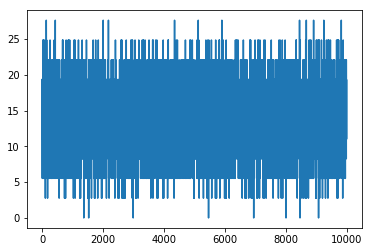

In [200]:
plt.plot(losses)
plt.show()

In [207]:
model(inputs)

/home/jkarimi91/Apps/miniconda2/envs/xor/lib/python2.7/site-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


Variable containing:
 0.6107  0.3893
 0.6030  0.3970
 0.5867  0.4133
 0.6060  0.3940
 0.5816  0.4184
 0.6091  0.3909
 0.5989  0.4011
 0.5761  0.4239
 0.5835  0.4165
 0.6115  0.3885
[torch.cuda.FloatTensor of size 10x2 (GPU 0)]

In [202]:
labels

Variable containing:
 1
 0
 1
 1
 1
 0
 1
 0
 1
 0
[torch.cuda.FloatTensor of size 10 (GPU 0)]

In [ ]:
help(LSTM)